# ANEMIA PREDICTION

## Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier
from xgboost import XGBRegressor
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve, auc
import warnings

## Data Preparation

Now i will create a wrangle function that imports and clean the Data set the fuction will be updated as i walk through sevral phases of Data Exploration

In [39]:
def wrangle(filepath):
    # read csv into DataFrame
    df = pd.read_csv(filepath)
    
    # Rename columns for better clarity and to facilitate analysis
    df.rename(columns={'Age in 5-year groups': 'age',
                       'Type of place of residence': 'residence',
                       'Highest educational level': 'educational_level',
                       'Wealth index combined': 'wealth_index',
                       'Births in last five years': 'births_5_years',
                       'Age of respondent at 1st birth': 'respondent_1st_birth',
                       'Hemoglobin level adjusted for altitude and smoking (g/dl - 1 decimal)': 'hemoglobin_altitude_smoking',
                       'Anemia level': 'anemia_level_target',
                       'Have mosquito bed net for sleeping (from household questionnaire)': 'mosquito_net_owners',
                       'Smokes cigarettes': 'smokers',
                       'Current marital status': 'marital_status',
                       'Currently residing with husband/partner': 'partner_residence',
                       'When child put to breast': 'child_put_breast',
                       'Had fever in last two weeks': 'fever_two_weeks',
                       'Hemoglobin level adjusted for altitude (g/dl - 1 decimal)': 'hemoglobin_altitude',
                       'Anemia level.1': 'anemia_level_1',
                       'Taking iron pills, sprinkles or syrup': 'iron_pills'}, inplace=True)
    
    # drop collumn with 50% null values .
    df.drop(columns="anemia_level_1" , inplace = True)
    
    # List of columns to impute
    columns_to_impute = ['hemoglobin_altitude_smoking','hemoglobin_altitude']

    # Convert relevant columns to numeric before imputing
    numeric_columns = columns_to_impute
    for column in numeric_columns:
        df[column] = pd.to_numeric(df[column], errors='coerce')

    # Impute missing values with mean
    for column in columns_to_impute:
        mean_value = df[column].mean()
        df[column].fillna(mean_value, inplace=True)
        
    # drop the column for high cardinality
    df.drop(columns="child_put_breast", inplace=True)  
    
    # Fill NaN values in specified columns with the string "Dont know"
    df['anemia_level_target'] = df['anemia_level_target'].fillna("Dont know") 
    
    #'Anemia level'  mapping
    category_mapping = {'Dont know': 0, 'Moderate': 1, 'Mild': 2, 'Not anemic': 3, 'Severe': 4}

    # Map the categories to numerical values
    df['anemia_level_target'] = df['anemia_level_target'].map(category_mapping)
    
    
    # define a function
    def replace_nan_with_word(x, word='Staying elsewhere'):
        """
        Replace NaN values in a pandas Series with a specified word.

        Parameters:
        - x: pandas Series
        - word: str, default='Staying elsewhere'
        """
        return x.fillna(word)

    # Apply the function to replace NaN values in the column
    df['partner_residence'] = replace_nan_with_word(df['partner_residence'])

    # Fill NaN values in the 'fever_two_weeks' column with the string "Dont know"
    df['fever_two_weeks'] = df['fever_two_weeks'].fillna("Dont know")
    
    # Fill NaN values in the 'iron_pills' column with the string "Dont know"
    df['iron_pills'] = df['iron_pills'].fillna("Dont know")
    

    return df

In [3]:
df = wrangle("children anemia.csv")
df.head()

,Age in 5-year groups,Type of place of residence,Highest educational level,Wealth index combined,Births in last five years,Age of respondent at 1st birth,Hemoglobin level adjusted for altitude and smoking (g/dl - 1 decimal),Anemia level,Have mosquito bed net for sleeping (from household questionnaire),Smokes cigarettes,Current marital status,Currently residing with husband/partner,When child put to breast,Had fever in last two weeks,Hemoglobin level adjusted for altitude (g/dl - 1 decimal),Anemia level.1,"Taking iron pills, sprinkles or syrup"
0,40-44,Urban,Higher,Richest,1,22,NaN,NaN,Yes,No,Living with partner,Staying elsewhere,Immediately,No,NaN,NaN,Yes
1,35-39,Urban,Higher,Richest,1,28,NaN,NaN,Yes,No,Married,Living with her,Hours: 1,No,NaN,NaN,No
2,25-29,Urban,Higher,Richest,1,26,NaN,NaN,No,No,Married,Living with her,Immediately,No,NaN,NaN,No
3,25-29,Urban,Secondary,Richest,1,25,95.0,Moderate,Yes,No,Married,Living with her,105.0,No,114.0,Not anemic,No
4,20-24,Urban,Secondary,Richest,1,21,NaN,NaN,Yes,No,No longer living together/separated,NaN,Immediately,No,NaN,NaN,No


In [4]:
df.info()
df.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33924 entries, 0 to 33923
Data columns (total 17 columns):
 #   Column                                                                 Non-Null Count  Dtype  
---  ------                                                                 --------------  -----  
 0   Age in 5-year groups                                                   33924 non-null  object 
 1   Type of place of residence                                             33924 non-null  object 
 2   Highest educational level                                              33924 non-null  object 
 3   Wealth index combined                                                  33924 non-null  object 
 4   Births in last five years                                              33924 non-null  int64  
 5   Age of respondent at 1st birth                                         33924 non-null  int64  
 6   Hemoglobin level adjusted for altitude and smoking (g/dl - 1 decimal)  13136 non-null 

(33924, 17)

Next I'll check for the number of Null values in each fatures of the Dataframe.

In [5]:
# check for null values
null_values = df.isnull().sum()
print(null_values)

Age in 5-year groups                                                         0
Type of place of residence                                                   0
Highest educational level                                                    0
Wealth index combined                                                        0
Births in last five years                                                    0
Age of respondent at 1st birth                                               0
Hemoglobin level adjusted for altitude and smoking (g/dl - 1 decimal)    20788
Anemia level                                                             20788
Have mosquito bed net for sleeping (from household questionnaire)            0
Smokes cigarettes                                                            0
Current marital status                                                       0
Currently residing with husband/partner                                   1698
When child put to breast                            

Next I'll rename features for better understanding and analysis.

In [6]:
# Rename columns for better clarity and to facilitate analysis

df.rename(columns={'Age in 5-year groups': 'age',
                   'Type of place of residence': 'residence',
                   'Highest educational level': 'educational_level',
                   'Wealth index combined': 'wealth_index',
                   'Births in last five years': 'births_5_years',
                   'Age of respondent at 1st birth': 'respondent_1st_birth',
                   'Hemoglobin level adjusted for altitude and smoking (g/dl - 1 decimal)': 'hemoglobin_altitude_smoking',
                   'Anemia level': 'anemia_level_target',
                   'Have mosquito bed net for sleeping (from household questionnaire)': 'mosquito_net_owners',
                   'Smokes cigarettes': 'smokers',
                   'Current marital status': 'marital_status',
                   'Currently residing with husband/partner': 'partner_residence',
                   'When child put to breast': 'child_put_breast',
                   'Had fever in last two weeks': 'fever_two_weeks',
                   'Hemoglobin level adjusted for altitude (g/dl - 1 decimal)': 'hemoglobin_altitude',
                   'Anemia level.1': 'anemia_level_1',
                   'Taking iron pills, sprinkles or syrup': 'iron_pills'}, inplace=True)

In [7]:
# Chcecking updated feature names 
df.columns

Index(['age', 'residence', 'educational_level', 'wealth_index',
       'births_5_years', 'respondent_1st_birth', 'hemoglobin_altitude_smoking',
       'anemia_level_target', 'mosquito_net_owners', 'smokers',
       'marital_status', 'partner_residence', 'child_put_breast',
       'fever_two_weeks', 'hemoglobin_altitude', 'anemia_level_1',
       'iron_pills'],
      dtype='object')

Next I'll check for features with more than 50% of null values and drop them 

In [8]:
missing_values = (df.isnull().sum()/len(df))*100
print(missing_values)

age                             0.000000
residence                       0.000000
educational_level               0.000000
wealth_index                    0.000000
births_5_years                  0.000000
respondent_1st_birth            0.000000
hemoglobin_altitude_smoking    61.278151
anemia_level_target            61.278151
mosquito_net_owners             0.000000
smokers                         0.000000
marital_status                  0.000000
partner_residence               5.005306
child_put_breast               37.601698
fever_two_weeks                 9.465275
hemoglobin_altitude            69.985851
anemia_level_1                 69.985851
iron_pills                      9.465275
dtype: float64


The Features (hemoglobin_altitude_smoking,anemia_level_target,anemia_level_1,hemoglobin_altitude) all have more than 50% Null but the aneamia and hemoglobin features are very important so i'll use the mean imputing startegy to fill them up. and drop the anemia_level_1 column  

In [24]:
# drop collumn with 50% null values .
df.drop(columns="anemia_level_1" , inplace = True)

In [9]:
# List of columns to impute
columns_to_impute = ['hemoglobin_altitude_smoking','hemoglobin_altitude']

# Convert relevant columns to numeric before imputing
numeric_columns = columns_to_impute
for column in numeric_columns:
    df[column] = pd.to_numeric(df[column], errors='coerce')

# Impute missing values with mean
for column in columns_to_impute:
    mean_value = df[column].mean()
    df[column].fillna(mean_value, inplace=True)

# Check if missing values are filled
missing_values_after_imputation = df.isnull().sum()
print("Missing values after imputation:\n", missing_values_after_imputation)


Missing values after imputation:
 age                                0
residence                          0
educational_level                  0
wealth_index                       0
births_5_years                     0
respondent_1st_birth               0
hemoglobin_altitude_smoking        0
anemia_level_target            20788
mosquito_net_owners                0
smokers                            0
marital_status                     0
partner_residence               1698
child_put_breast               12756
fever_two_weeks                 3211
hemoglobin_altitude                0
anemia_level_1                 23742
iron_pills                      3211
dtype: int64


Next I'll check for cardinality 

In [10]:
#Cardinality check
df.select_dtypes("object").nunique()

age                     7
residence               2
educational_level       4
wealth_index            5
anemia_level_target     4
mosquito_net_owners     2
smokers                 2
marital_status          6
partner_residence       2
child_put_breast       41
fever_two_weeks         3
anemia_level_1          4
iron_pills              3
dtype: int64

It can be seen that the child_put_breast feature pocesses high cardinality hence i'll drop the feature.

In [11]:
# drop the column for high cardinality
df.drop(columns="child_put_breast", inplace=True)

Next i'll check for the disribution of age using a Histogram 

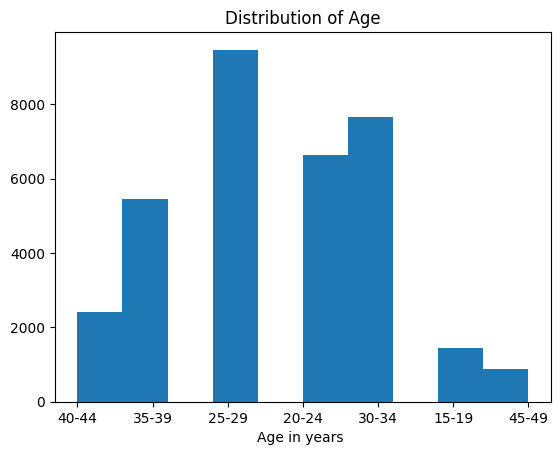

In [12]:
plt.hist(df["age"])
plt.xlabel("Age in years ")
plt.title("Distribution of Age");

From the the histogram it can be seen that the anemia is predominant amongst the 25-29 year old .

Next i'll  look out for is multicollinearity, that is, features in our feature matrix that are highly correlated with each other. A good way to detect this is to use a heatmap and investigate the results.

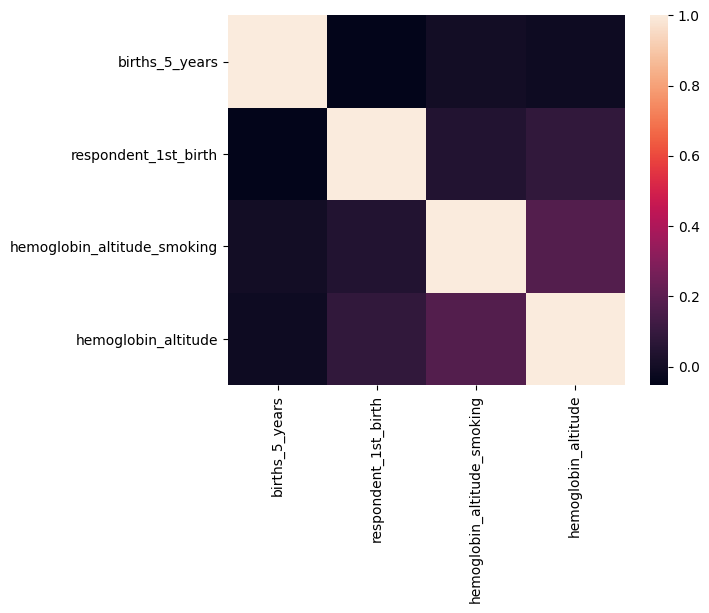

In [13]:
# Heat map plot
corr = df.select_dtypes("number").corr()
sns.heatmap(corr);

From the results it can be seen that the other features are not correlated with each other.

Next ill fill in the null values in my target variable with  the string "dont know"

In [17]:
# Fill NaN values in specified columns with the string "Dont know"
df['anemia_level_target'] = df['anemia_level_target'].fillna("Dont know")

Next i'll code the target varible with numerical values.

In [20]:
#'Anemia level'  mapping
category_mapping = {'Dont know': 0, 'Moderate': 1, 'Mild': 2, 'Not anemic': 3, 'Severe': 4}

# Map the categories to numerical values
df['anemia_level_target'] = df['anemia_level_target'].map(category_mapping)

# Display the updated DataFrame
print(df.head())


     age residence educational_level wealth_index  births_5_years  \
0  40-44     Urban            Higher      Richest               1   
1  35-39     Urban            Higher      Richest               1   
2  25-29     Urban            Higher      Richest               1   
3  25-29     Urban         Secondary      Richest               1   
4  20-24     Urban         Secondary      Richest               1   

   respondent_1st_birth  hemoglobin_altitude_smoking  anemia_level_target  \
0                    22                   114.367235                    0   
1                    28                   114.367235                    0   
2                    26                   114.367235                    0   
3                    25                    95.000000                    1   
4                    21                   114.367235                    0   

  mosquito_net_owners smokers                       marital_status  \
0                 Yes      No                  Livin

Next i'll treat all other features with null values 

Taking the residing_husband_patner feature into consideration

In [28]:
# define a function
def replace_nan_with_word(x, word='Staying elsewhere'):
    """
    Replace NaN values in a pandas Series with a specified word.

    Parameters:
    - x: pandas Series
    - word: str, default='Staying elsewhere'
    """
    return x.fillna(word)

# Apply the function to replace NaN values in the column
df['partner_residence'] = replace_nan_with_word(df['partner_residence'])


Next ill consider the fever_two_weeks and iron_pills  features

In [35]:
# Fill NaN values in the 'fever_two_weeks' column with the string "Dont know"

df['fever_two_weeks'] = df['fever_two_weeks'].fillna("Dont know")

In [37]:
# Fill NaN values in the 'iron_pills' column with the string "Dont know"
df['iron_pills'] = df['iron_pills'].fillna("Dont know")

I'll now update my wrangle function with all the steps taking for exploration and cleaning 

In [38]:
# inspect the data frame 
df.head(10)

,age,residence,educational_level,wealth_index,births_5_years,respondent_1st_birth,hemoglobin_altitude_smoking,anemia_level_target,mosquito_net_owners,smokers,marital_status,partner_residence,fever_two_weeks,hemoglobin_altitude,iron_pills
0,40-44,Urban,Higher,Richest,1,22,114.367235,0,Yes,No,Living with partner,Staying elsewhere,No,101.270183,Yes
1,35-39,Urban,Higher,Richest,1,28,114.367235,0,Yes,No,Married,Living with her,No,101.270183,No
2,25-29,Urban,Higher,Richest,1,26,114.367235,0,No,No,Married,Living with her,No,101.270183,No
3,25-29,Urban,Secondary,Richest,1,25,95.000000,1,Yes,No,Married,Living with her,No,114.000000,No
4,20-24,Urban,Secondary,Richest,1,21,114.367235,0,Yes,No,No longer living together/separated,Staying elsewhere,No,101.270183,No
5,30-34,Urban,Higher,Richest,1,30,113.000000,2,Yes,No,Married,Living with her,No,119.000000,No
6,35-39,Urban,Secondary,Richest,2,32,121.000000,3,Yes,No,Married,Living with her,No,102.000000,Yes
7,35-39,Urban,Secondary,Richest,2,32,121.000000,3,Yes,No,Married,Living with her,Dont know,101.270183,Dont know
8,30-34,Urban,Secondary,Richest,1,32,114.367235,0,Yes,No,Married,Living with her,No,101.270183,No
9,20-24,Urban,Secondary,Richest,1,19,108.000000,1,Yes,No,Married,Living with her,No,113.000000,Yes
